# Notebook containing the figures

In [13]:
import torch
import matplotlib.pyplot as plt 
import os
import datetime
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
FOLDER = 'figures'
SIMULATION_FOLDER = 'simulations'
GRAPHS_ID = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
graph_folder = os.path.join(FOLDER, GRAPHS_ID)
os.makedirs(graph_folder, exist_ok=True)
n_iterations = 10

## Functions used for positive and negative updates

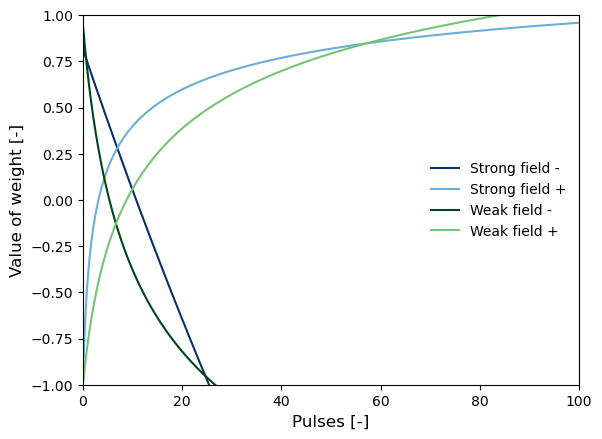

In [14]:
scale = 1
f_strong_minus = lambda x: scale * (2*(-24.77 * \
                torch.log(0.287*torch.log(x+128))+9.11)-1)
f_strong_plus = lambda x: scale * (2*(0.443 * \
                torch.log(2.53*torch.log(x+1.66)) - 0.11)-1)

f_weak_minus = lambda x: scale * \
                (-2.56*torch.log(0.997*torch.log(x+5.02)) + 2.166)
f_weak_plus = lambda x: scale * \
                (1.8132 * torch.log(1.176*torch.log(x+4.42))-2.014)
# plot all functions
fig, ax = plt.subplots()
x = torch.linspace(0, 100, 1000)
shades_blue = plt.get_cmap('Blues_r', 3)
shades_green = plt.get_cmap('Greens_r', 3)
ax.plot(x, f_strong_minus(x), label="Strong field -", color=shades_blue(0))
ax.plot(x, f_strong_plus(x), label="Strong field +", color=shades_blue(1))
ax.plot(x, f_weak_minus(x), label="Weak field -", color=shades_green(0))
ax.plot(x, f_weak_plus(x), label="Weak field +", color=shades_green(1))
ax.legend(loc='center right', fontsize=10, frameon=False)
ax.set_xlabel("Pulses [-]", fontsize=12)
ax.set_ylabel("Value of weight [-]", fontsize=12)
# export
name = "weight-evolution-" + GRAPHS_ID
ax.set_ylim(-scale, scale)
ax.set_xlim(0, 100)
fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')

## Load dataframe from simulation

In [15]:
# Create a pandas dataframe with columns type, mean, std, learning rate
df = pd.DataFrame(columns=["task", "type_devices", "n_devices", "accuracies", "learning_rate", "weights_path", "mean", "std", "scale", "noise", "mean_abs_grad"])
# get all paths
paths = [f for f in os.listdir(SIMULATION_FOLDER) if os.path.isdir(os.path.join(SIMULATION_FOLDER, f))]
for path in paths:
    try:
        # first dim of the tensor is the iteration
        accuracies = []
        mean_abs_grad = []
        weights = ""
        for it in range(n_iterations):
            current_folder = os.path.join(SIMULATION_FOLDER, path)
            accuracies.append(torch.load(os.path.join(current_folder, path+f"-{it}-accuracies.pth")))
            mean_abs_grad.append(torch.load(os.path.join(current_folder, path+f"-{it}-gradients.pth")))
            if it == 0:
                weights = path+f"-{it}-weights.pth"     
        accuracies = torch.stack(accuracies)    
        mean = accuracies.mean(dim=0)[-1].item()*100
        std = accuracies.std(dim=0)[-1].item()*100
        mean_abs_grad = torch.stack(mean_abs_grad).mean(dim=0)[0].item()
        task = path.split("-")[1]
        n_devices = path.split("-")[2]
        type_devices = path.split("-")[3]
        learning_rate = float(path.split("-")[4])
        scale = float(path.split("-")[8])
        noise = float(path.split("-")[10])
        df = df.append({"task": task, 
                        "type_devices": type_devices, 
                        "n_devices": n_devices, 
                        "accuracies": accuracies, 
                        "learning_rate": learning_rate, 
                        "weights_path": weights, 
                        "mean": mean, 
                        "std": std,
                        "mean_abs_grad": mean_abs_grad,
                        "noise": noise,
                        "scale": scale}, ignore_index=True)
    except Exception as e:
        pass
df

,task,type_devices,n_devices,accuracies,learning_rate,weights_path,mean,std,scale,noise,mean_abs_grad
0,MNIST,linear,double,"[[tensor(0.9601), tensor(0.9657), tensor(0.966...",0.5,20240724133505-MNIST-double-linear-0.5-switch-...,97.151995,0.118958,1.0,0.0,0.000912
1,MNIST,linear,double,"[[tensor(0.9607), tensor(0.9664), tensor(0.967...",1.0,20240724133658-MNIST-double-linear-1.0-switch-...,97.156000,0.108546,1.0,0.0,0.001296


## Accuracy vs learning rate

Plotting task MNIST with noise 0.0


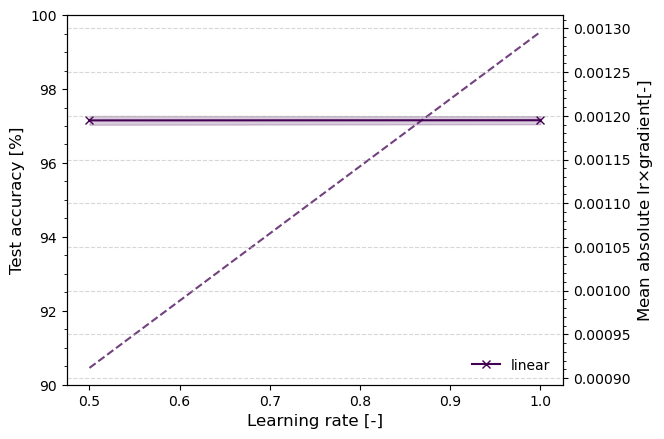

In [19]:
# for each task, plot the evolution of the accuracy
for task in df["task"].unique():
    for noise in df["noise"].unique():
        print(f"Plotting task {task} with noise {noise}")
        fig, ax = plt.subplots()
        ax2 = ax.twinx()
        palette = plt.get_cmap('viridis', len(df["type_devices"].unique())+1)
        df_filtered = df[(df["task"] == task) & (df["noise"] == noise)].sort_values("learning_rate")
        for i, (name, group) in enumerate(df_filtered.groupby("type_devices")):
            ax.plot(group["learning_rate"], group["mean"], label=name, color=palette(i), marker='x')
            ax.fill_between(group["learning_rate"], group["mean"]-group["std"], group["mean"]+group["std"], alpha=0.2, color=palette(i))
            ax2.plot(group["learning_rate"], group["mean_abs_grad"], linestyle='--', color=palette(i), alpha=0.75, zorder=-1)
        # for lr in df_filtered["learning_rate"].unique():
        #     ax.axvline(lr, color='black', linestyle='--', alpha=0.1, zorder=-1)
        ax2.grid(axis='y', which='major', linestyle='--', alpha=0.5)
        ax2.set_ylabel(r"Mean absolute lr$\times$gradient[-]", fontsize=12)
        ax.set_xlabel("Learning rate [-]", fontsize=12)
        ax.set_ylabel("Test accuracy [%]", fontsize=12)
        ax.legend(loc='lower right', fontsize=10, frameon=False)
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax2.yaxis.set_minor_locator(AutoMinorLocator())
        offset = 5
        minimum = 90 if task == "MNIST" else 80
        maximum = min(100, df_filtered["mean"].max() + offset)
        ax.set_ylim([minimum, maximum])
        ax.set_ylim([minimum, maximum])
        plt.show()
        # save as pdf and svg
        name = f"learning-rate-{task}-noise-{noise}-{GRAPHS_ID}"
        fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')